In [3]:
from tensorflow.keras.layers import Conv2D,Flatten,Dense,MaxPool2D,BatchNormalization,GlobalAveragePooling2D,Dropout
from tensorflow.keras.applications.resnet50 import preprocess_input,decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import PIL
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

In [4]:
img_height,img_width = (224,224)
batch_size = 32
train_data_dir = r"C:\\Users\\Admin\\machine learning\\machine learnig\\stage_ete_02\\test_sexe\\test_resnet\\output_sexe\\train"
valid_data_dir = r"C:\\Users\\Admin\\machine learning\\machine learnig\\stage_ete_02\\test_sexe\\test_resnet\\output_sexe\\val"
test_data_dir = r"C:\\Users\\Admin\\machine learning\\machine learnig\\stage_ete_02\\test_sexe\\test_resnet\\output_sexe\\test"

In [5]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.4)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height,img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training') # set as training data

valid_generator=train_datagen.flow_from_directory(
    valid_data_dir,#same directory as training data
    target_size=(img_height,img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')#set as validation data

Found 1215 images belonging to 2 classes.
Found 44 images belonging to 2 classes.


In [6]:
test_generator=train_datagen.flow_from_directory(
    test_data_dir,#same directory as training data
    target_size=(img_height,img_width),
    batch_size=1,
    class_mode='categorical',
    subset='validation')#set as validation data

Found 45 images belonging to 2 classes.


In [7]:
x,y = test_generator.next()
x.shape

(1, 224, 224, 3)

In [8]:
base_model = ResNet50(include_top=False,weights='imagenet',input_shape=(img_height,img_width,3))

for layer in base_model.layers:
    layer.trainable=False
    
    
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024,activation='relu')(x)
x = Dense(512,activation='relu')(x)
x = Dense(256,activation='relu')(x)

x = Dense(64,activation='relu')(x)
                     
predictions = Dense(train_generator.num_classes,activation='softmax')(x)
model = Model(inputs=base_model.input ,outputs=predictions)


In [9]:
    
model.compile(optimizer='adam',loss='binary_crossentropy' ,metrics=['accuracy'])
model.fit(train_generator,
                         epochs = 90)

Epoch 1/90
38/38 [==============================] - 80s 2s/step - loss: 0.6258 - accuracy: 0.6922
Epoch 2/90
38/38 [==============================] - 68s 2s/step - loss: 0.4208 - accuracy: 0.8239
Epoch 3/90
38/38 [==============================] - 66s 2s/step - loss: 0.4184 - accuracy: 0.8115
Epoch 4/90
38/38 [==============================] - 64s 2s/step - loss: 0.3775 - accuracy: 0.8222
Epoch 5/90
38/38 [==============================] - 62s 2s/step - loss: 0.2931 - accuracy: 0.8724
Epoch 6/90
38/38 [==============================] - 62s 2s/step - loss: 0.2723 - accuracy: 0.8889
Epoch 7/90
38/38 [==============================] - 61s 2s/step - loss: 0.2504 - accuracy: 0.9045
Epoch 8/90
38/38 [==============================] - 64s 2s/step - loss: 0.2482 - accuracy: 0.8979
Epoch 9/90
38/38 [==============================] - 66s 2s/step - loss: 0.2080 - accuracy: 0.9128
Epoch 10/90
38/38 [==============================] - 69s 2s/step - loss: 0.2150 - accuracy: 0.9086
Epoch 11/90
38/38 [

In [10]:
model.save('C:\\Users\\Admin\\machine learning\\machine learnig\\stage_ete_02\\test_sexe\\save_test\\ResNet50_sexee.h5' )

In [11]:
test_loss,test_acc = model.evaluate(test_generator, verbose=2)
print('\ntest accuracy:' , test_acc)

45/45 - 5s - loss: 1.3412 - accuracy: 0.6667 - 5s/epoch - 101ms/step

test accuracy: 0.6666666865348816


1/1 [==============================] - 0s 26ms/step


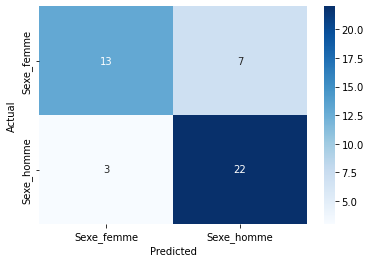

test accuracy:77.77777777777779


In [12]:
model = tf.keras.models.load_model("C:\\Users\\Admin\\machine learning\\machine learnig\\stage_ete_02\\test_sexe\\save_test\\ResNet50_sexe.h5")
filenames = test_generator.filenames
nb_samples = len(test_generator)
y_prob=[]
y_act=[]
test_generator.reset()
for _ in range(nb_samples):
    X_test,Y_test = test_generator.next()
    y_prob.append(model.predict(X_test))
    y_act.append(Y_test)

predicted_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_prob]
actual_class = [list(train_generator.class_indices.keys())[i.argmax()]for i in y_act]

out_df = pd.DataFrame(np.vstack([predicted_class,actual_class]).T,columns=['predicted_class','actual_class'])
confusion_matrix = pd.crosstab(out_df['actual_class'],out_df['predicted_class'],rownames=['Actual'],colnames=['Predicted'])

sns.heatmap(confusion_matrix,cmap='Blues',annot=True,fmt='d')
plt.show()
print('test accuracy:{}'.format((np.diagonal(confusion_matrix).sum()/confusion_matrix.sum().sum()*100)))